# Integrantes do grupo:
# Andreza Lukosiunas - @andrezasp (nusp: 7157922)
# Juliano Garcia - @robotenique (nusp: 9277086)
# Pedro Carvalho - @pHrfo (nusp: 11376164)

In [1]:
# Pacotes utilizados

# Conectar-se ao Drive
from google.colab import drive

# https://docs.python.org/3/library/os.html
import os

# https://matplotlib.org/
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path as mpath

# https://pandas.pydata.org/
import pandas as pd

# https://numpy.org/
import numpy as np

# https://docs.python.org/3/library/itertools.html
import itertools

# https://pypi.org/project/Pillow/
from PIL import Image

# skimage para carregar as imagens
# https://scikit-image.org/
import skimage
from skimage import data
from skimage.morphology import disk, ball, watershed
from skimage.filters.rank import gradient
from skimage import filters
from skimage.filters import threshold_otsu
from skimage.filters import median, gaussian
from skimage.filters import sobel, roberts, scharr
from skimage import segmentation

# https://scikit-image.org/docs/dev/api/skimage.io.html
from skimage import io

# https://pypi.org/project/opencv-python/
import cv2

# https://pypi.org/project/tqdm/
# from tqdm import tqdm
from tqdm.notebook import tqdm

# https://docs.python.org/3/library/shutil.html
import shutil

# https://docs.python.org/3/library/pathlib.html
from pathlib import Path

# https://docs.python.org/3/library/glob.html
import glob

# https://docs.python.org/3/library/collections.html
from collections import Counter

# https://docs.python.org/3/library/math.html
import math

# https://docs.python.org/3/library/json.html
import json

# https://joblib.readthedocs.io/en/latest/
import joblib

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
from sklearn.metrics import classification_report

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
from sklearn.metrics import plot_precision_recall_curve

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html
rom sklearn.preprocessing import label_binarize

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
os.chdir('/content/gdrive/My Drive/MAC5768 - Visão computacional/')

In [4]:
metadados = pd.read_csv("metadados/metadados_full.csv")

In [5]:
metadados.head()

,Unnamed: 0,arquivo,convertida,normalizada,classe,objecto,repeticao,fundo,iluminacao,local,resolucao,tamanho
0,0,20210417_153013.jpg,20210417_153013_gray.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
1,1,20210417_153013.jpg,20210417_153013_grad.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
2,2,20210417_153013.jpg,20210417_153013_excgrad.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
3,3,20210417_153013.jpg,20210417_153013_log.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0
4,4,20210417_153013.jpg,20210417_153013_exp.jpg,NaN,óculos,óculos gucci,1.0,branco_2,dia,interno,2560x1440,1144814.0


# EP3 - Parte 2 - PCA e Classificador SVM

## Transforma a numpy array de dimensão M X N para (M X N) X 1 com flatten 

In [6]:
descriptors = []

for file in tqdm(metadados.convertida):
  descriptors += [joblib.load(f"segmented/{file}.joblib").flatten()]

In [7]:
df = pd.DataFrame(descriptors)
df.shape

(11088, 4704)

## Define o target

In [8]:
df["target"] = metadados.classe

## Separa 75% das observações para treino e 25% para teste

In [9]:
train_df = df.sample(frac=0.75)
test_df = df[~df.index.isin(train_df.index)]

In [10]:
X_train = train_df[[col for col in train_df.columns if col != "target"]]
y_train = train_df["target"]

X_test = test_df[[col for col in test_df.columns if col != "target"]]
y_test = test_df["target"]

## Diminui dimensionalidade dos dados com PCA de 50 componentes  

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

## Define classificador SVM e escolhe melhores hiperparâmetros com gridSearchCV

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

params = {
    "kernel": ["linear", "rbf"],
    "C": [1, 1e-2, 5],
}

cv = GridSearchCV(SVC(random_state=42), params, scoring="f1_macro", verbose=10, cv=3)

In [13]:
cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. C=1, kernel=linear, score=0.670, total=  12.5s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV] .................. C=1, kernel=linear, score=0.672, total=  10.4s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s


[CV] .................. C=1, kernel=linear, score=0.676, total=  11.4s
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.3s remaining:    0.0s


[CV] ..................... C=1, kernel=rbf, score=0.674, total=   4.0s
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.3s remaining:    0.0s


[CV] ..................... C=1, kernel=rbf, score=0.673, total=   4.0s
[CV] C=1, kernel=rbf .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.2s remaining:    0.0s


[CV] ..................... C=1, kernel=rbf, score=0.689, total=   4.0s
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.3s remaining:    0.0s


[CV] ............... C=0.01, kernel=linear, score=0.630, total=   2.8s
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.1s remaining:    0.0s


[CV] ............... C=0.01, kernel=linear, score=0.622, total=   2.8s
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.0s remaining:    0.0s


[CV] ............... C=0.01, kernel=linear, score=0.633, total=   2.8s
[CV] C=0.01, kernel=rbf ..............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   54.8s remaining:    0.0s


[CV] .................. C=0.01, kernel=rbf, score=0.084, total=   7.3s
[CV] C=0.01, kernel=rbf ..............................................
[CV] .................. C=0.01, kernel=rbf, score=0.075, total=   7.3s
[CV] C=0.01, kernel=rbf ..............................................
[CV] .................. C=0.01, kernel=rbf, score=0.083, total=   7.3s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.677, total=  55.3s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.674, total=  46.5s
[CV] C=5, kernel=linear ..............................................
[CV] .................. C=5, kernel=linear, score=0.676, total=  37.7s
[CV] C=5, kernel=rbf .................................................
[CV] ..................... C=5, kernel=rbf, score=0.711, total=   3.4s
[CV] C=5, kernel=rbf .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 0.01, 5], 'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=10)

## Report das métricas no treino

In [14]:
preds_train = cv.predict(X_train_pca)
print(classification_report(y_train, preds_train))

              precision    recall  f1-score   support

        book       0.98      0.76      0.86       930
      caneta       0.86      0.62      0.72       587
     charger       0.86      0.71      0.78       925
      colher       0.31      0.96      0.47       958
       knife       0.96      0.82      0.88       955
     mascara       0.99      0.59      0.74       563
        meia       0.97      0.52      0.67       566
  necessaire       0.98      0.57      0.72       757
      xícara       0.93      0.63      0.75      1142
      óculos       0.93      0.79      0.86       933

    accuracy                           0.71      8316
   macro avg       0.88      0.70      0.74      8316
weighted avg       0.87      0.71      0.75      8316



## Report das métricas no teste

In [15]:
preds_test = cv.predict(X_test_pca)
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

        book       0.94      0.75      0.84       330
      caneta       0.81      0.56      0.66       169
     charger       0.85      0.70      0.77       335
      colher       0.29      0.95      0.45       302
       knife       0.95      0.82      0.88       305
     mascara       0.96      0.50      0.66       193
        meia       0.90      0.51      0.65       190
  necessaire       0.99      0.57      0.73       251
      xícara       0.88      0.58      0.70       370
      óculos       0.92      0.79      0.85       327

    accuracy                           0.69      2772
   macro avg       0.85      0.67      0.72      2772
weighted avg       0.85      0.69      0.73      2772



## Curvas de precision e recall

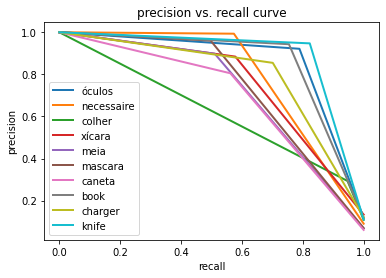

In [37]:
# precision recall curve
classes = list(y_test.unique())
y_test_2 = label_binarize(y_test, classes=classes)
preds_test_2 = label_binarize(preds_test, classes=classes)

precision = dict()
recall = dict()
for i in range(10):
# for i in classes:
    precision[i], recall[i], _ = precision_recall_curve(y_test_2[:, i],
                                                        preds_test_2[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='{}'.format(classes[i]))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

## Conclusão: De modo geral, o classificador ficou muito bom, o f1-score geral acima de 70% indica resultado maior que o palpite aleatório. A colher obteve o menor f1-score, esse fato deve ter ocorrido porque uma das colheres tinha um tamanho bem maior do que a média entre elas. Podemos observar que não houve overfitting já que os dados de treino apresentam maior score em relação aos de teste.